# MESSI Cluster Analysis

This notebook improves feature engineering & re-runs cluster analysis. 

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import imageio
from IPython.display import display
sns.set_theme() # changes more defaults

In [210]:
# TODO:

# write `plot_feature_2d` (feature space in 2D / two features)
# "regress" cluster performance evaluation & oder wie quantifizieren
# & dann zwischen feature auswahl vergleichen?
# mit Stadtklima vergleichen:
# https://www.berlin.de/umweltatlas/klima/klimaanalyse/2014/karten/artikel.1024091.php

## Data Import

In [211]:
# data import
tmp_ftrs_old = pd.read_csv("../data/tmp_ftrs.csv")
messi_loc = pd.read_csv("../data/messi_location_clean.csv")
tmp_raw = pd.read_csv("../data/tmp.csv", parse_dates=[0], low_memory=False)

## Feature Engineering

Folgende Parameter wurden bereits im notebook #1 berechnet und werden importiert:
- Differenz der Tageshöchst- und tiefstwerte $  \Delta T_{max} - \Delta T_{min} $ (`diff`)
- Arithmetisches Mittel $  \overline{\Delta T} $ (`mean_dev`)
- Standardabweichung $  \sigma  \Delta T $ (`std_dev`)
- Altitude (`alt`)

Als neue Parameter werden berechnet:
- Mittelwert und Standardabweichung der MESSI-Temperaturwerte (ohne Abweichung vom dwd-Tagesmittel) (`mean`, `std`)
- (Mittlere) Abweichung vom dwd-Mittel *für jeden Zeitschritt*, d. h. keine dwd-Tagesmitteltemperatur (`dev`)

In [212]:
# mean
tmp_ftrs_new = (tmp_raw
    [tmp_raw.origin == "messi"]
    .groupby(["day", "id"], as_index=False)
    ["tmp"].mean()
    .rename(columns={"tmp": "mean"})
)

# std
tmp_ftrs_new["std"] = (tmp_raw
    [tmp_raw.origin == "messi"]
    .groupby(["day", "id"])
    ["tmp"].std()
    .values
)

# deviation from dwd-mean
dwd_mean = (tmp_raw
    [tmp_raw.origin == "dwd"]
    .groupby("time_measured", as_index=False)
    ["tmp"].mean()
    .rename(columns={"tmp": "dwd_mean"})
)

messi_dev = (tmp_raw
    [tmp_raw.origin == "messi"]
    .merge(right=dwd_mean, on="time_measured")
)

messi_dev["dev"] = messi_dev["tmp"] - messi_dev["dwd_mean"]

tmp_ftrs_new["dev"] = (messi_dev
    .groupby(["day", "id"])
    ["dev"].mean()
    .values
)

tmp_ftrs_new

,day,id,mean,std,dev
0,1,2,21.287037,2.018889,0.680556
1,1,8,21.518014,2.091451,0.832730
2,1,9,NaN,NaN,NaN
3,1,13,NaN,NaN,NaN
4,1,17,21.904618,1.485958,1.225278
...,...,...,...,...,...
987,31,74,18.489000,3.603771,1.489476
988,31,80,18.212664,3.568107,1.232372
989,31,85,NaN,NaN,NaN
990,31,88,19.093776,3.760315,1.387993


In [213]:
# joining "old" and "new" features
tmp_ftrs = pd.merge(
    left=tmp_ftrs_new,
    right=tmp_ftrs_old,
    how="inner",
    on=["day", "id"],
    suffixes=(None, "_dev")
).drop(columns=["dmin", "dmax"])

tmp_ftrs

,day,id,mean,std,dev,alt,diff,mean_dev,std_dev,nans
0,1,2,21.287037,2.018889,0.680556,42.0,7.810,0.607697,2.018889,36
1,1,8,21.518014,2.091451,0.832730,34.0,11.220,0.838674,2.091451,3
2,1,9,NaN,NaN,NaN,72.0,NaN,NaN,NaN,144
3,1,13,NaN,NaN,NaN,52.0,NaN,NaN,NaN,144
4,1,17,21.904618,1.485958,1.225278,34.0,6.180,1.225278,1.485958,0
...,...,...,...,...,...,...,...,...,...,...
987,31,74,18.489000,3.603771,1.489476,42.0,12.220,1.449417,3.603771,4
988,31,80,18.212664,3.568107,1.232372,40.0,12.075,1.173081,3.568107,7
989,31,85,NaN,NaN,NaN,72.0,NaN,NaN,NaN,144
990,31,88,19.093776,3.760315,1.387993,44.0,13.530,2.054192,3.760315,46


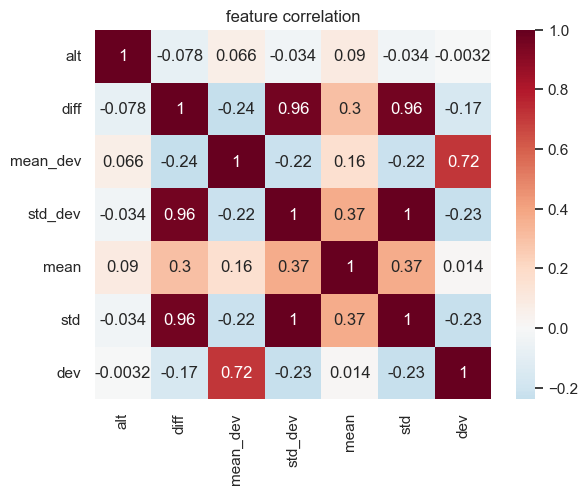

In [214]:
cols = ["alt", "diff", "mean_dev", "std_dev", "mean", "std", "dev"]

# .corr() method computes pairwise correlation of columns
data = tmp_ftrs[cols].corr(method="pearson")

fig, ax = plt.subplots()
sns.heatmap(data=data, annot=True, cmap="RdBu_r", center=0.0, ax=ax)
ax.set_title("feature correlation");
#fig.savefig("../figs/.png", dpi=300, bbox_inches="tight")

Überraschenderweise korrelieren die beiden Mittelwerte wenig. Kann das daran liegen, dass `mean_dev` negative Werte besitzt?

In [215]:
# standardize features by removing the mean and scaling to unit variance
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
scaler = StandardScaler()
tmp_ftrs_scaled = pd.DataFrame(
    scaler.fit_transform(tmp_ftrs[cols]),
    columns=cols, index=tmp_ftrs.index
).merge(
    right=tmp_ftrs[["day", "id", "nans"]],
    left_index=True, right_index=True  
)
tmp_ftrs_scaled

,alt,diff,mean_dev,std_dev,mean,std,dev,day,id,nans
0,-0.263605,-1.202106,0.125202,-1.292880,-0.246605,-1.292880,0.224301,1,2,36
1,-1.057523,-0.555896,0.301644,-1.253173,-0.167880,-1.253173,0.383006,1,8,3
2,2.713586,NaN,NaN,NaN,NaN,NaN,NaN,1,9,144
3,0.728792,NaN,NaN,NaN,NaN,NaN,NaN,1,13,144
4,-1.057523,-1.510999,0.596967,-1.584504,-0.036113,-1.584504,0.792398,1,17,0
...,...,...,...,...,...,...,...,...,...,...
987,-0.263605,-0.366392,0.768185,-0.425619,-1.200269,-0.425619,1.067933,31,74,4
988,-0.462085,-0.393870,0.557094,-0.445135,-1.294454,-0.445135,0.799797,31,80,7
989,2.713586,NaN,NaN,NaN,NaN,NaN,NaN,31,85,144
990,-0.065126,-0.118141,1.230168,-0.339958,-0.994142,-0.339958,0.962096,31,88,46


## Clustering

For single day:
1. Compute optimal number of clusters with elbow-method (`elbow`)
2. Optional: Visualize clusters in feature space (`plot_feature_space_3d`)
3. Optional: Investigate some parameters of found clusters (`plot_params`)

For all days:
1. Run kmeans-clustering for every day individually & create animation of results for entire time interval (`find_clusters`, `anim_clusters`)
2. Optional: Visualize SSE for all clusterings (`plot_sse`)
3. Evaluate consistency of clusters throughout time interval (`eval_similarity`)

In [216]:
def elbow(ftrs, nday, max_n_clusters=10, data=tmp_ftrs_scaled):
    """
    Compute SSE for multiple number of clusters.
    """
    # kmeans cannot handle missing values, rows containing missing values are going
    # to be removed
    day_ftrs = data[data.day == nday][ftrs].dropna()

    sse = {}
    for k in range(1,max_n_clusters+1):
        kmeans = KMeans(
            n_clusters=k,
            init="k-means++", # initializes the centroids to be (generally) distant from each other
            n_init=10,        # # of times kmeans is run with different centroid seeds
            random_state=42,  # for reproducibility
        ).fit(
            day_ftrs # shape (n_samples, n_features)
        )
        # output some information
        print(
            "# of clusters", k,
            "\t# of iterations:", kmeans.n_iter_,
            "\t# of features:", kmeans.n_features_in_
        )
        # and save evaluation metric
        sse[k] = kmeans.inertia_ # sum of squared distances

    fig, ax = plt.subplots()
    ax.plot(list(sse.keys()), list(sse.values()))
    ax.grid(False)
    ax.set_title(f"elbow method | {nday} | {', '.join(ftrs)}")
    ax.set_xlabel("# of clusters")
    ax.set_ylabel("SSE");

# of clusters 1 	# of iterations: 2 	# of features: 3
# of clusters 2 	# of iterations: 2 	# of features: 3
# of clusters 3 	# of iterations: 5 	# of features: 3
# of clusters 4 	# of iterations: 3 	# of features: 3
# of clusters 5 	# of iterations: 3 	# of features: 3
# of clusters 6 	# of iterations: 3 	# of features: 3
# of clusters 7 	# of iterations: 3 	# of features: 3
# of clusters 8 	# of iterations: 3 	# of features: 3
# of clusters 9 	# of iterations: 3 	# of features: 3
# of clusters 10 	# of iterations: 2 	# of features: 3
# of clusters 1 	# of iterations: 2 	# of features: 3
# of clusters 2 	# of iterations: 3 	# of features: 3
# of clusters 3 	# of iterations: 6 	# of features: 3
# of clusters 4 	# of iterations: 6 	# of features: 3
# of clusters 5 	# of iterations: 5 	# of features: 3
# of clusters 6 	# of iterations: 4 	# of features: 3
# of clusters 7 	# of iterations: 5 	# of features: 3
# of clusters 8 	# of iterations: 3 	# of features: 3
# of clusters 9 	# of itera

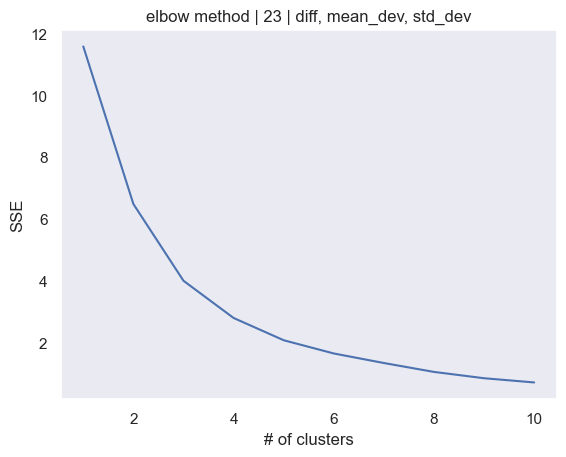

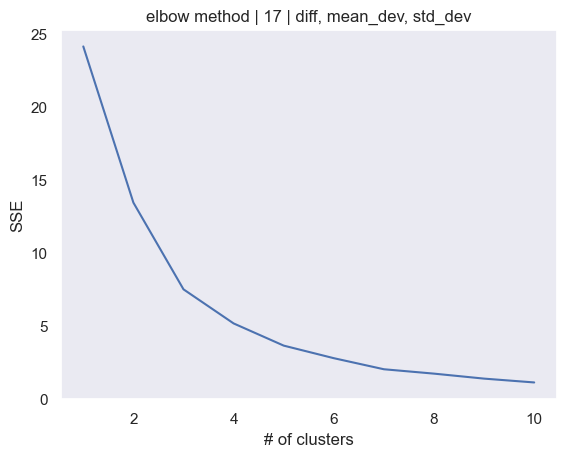

In [217]:
ftrs = ["diff", "mean_dev", "std_dev"] # default features
nday = 23

elbow(ftrs, nday)
elbow(ftrs, nday=17)

In [218]:
n_clusters = 3

In [219]:
# helper function
def kmeans_single_day(n_clusters, ftrs, nday, data):
    # get features
    ftrs_df = data[data.day == nday].dropna()[ftrs]
    # clustering...
    kmeans = KMeans(
        n_clusters=n_clusters, 
        init="k-means++", 
        n_init=10, 
        random_state=42
    ).fit(
        ftrs_df
    )
    return kmeans, ftrs_df

In [220]:
def plot_feature_space_3d(n_clusters, ftrs, nday, data=tmp_ftrs_scaled, plot_cluster_center=True):
    # clustering
    kmeans, ftrs_df = kmeans_single_day(n_clusters, ftrs, nday, data)
    # plotting (visualize clusters in feature space)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d", "elev": 48, "azim": 134})
    ax.scatter(ftrs_df.iloc[:, 0], ftrs_df.iloc[:, 1], ftrs_df.iloc[:, 2],
               c=kmeans.labels_, edgecolor="k", cmap="viridis", s=60)
    if plot_cluster_center:
        ax.scatter(
            kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            kmeans.cluster_centers_[:, 2],
            c=list(range(n_clusters)), # = [0, 1, 2] to give cc's same colour
            cmap="viridis", ec="k", marker="X",
        )
    ax.set_xlabel(ftrs[0])
    ax.set_ylabel(ftrs[1])
    ax.set_zlabel(ftrs[2])
    ax.set_title(rf"feature space, day$ = {nday}$, $k={n_clusters}$")

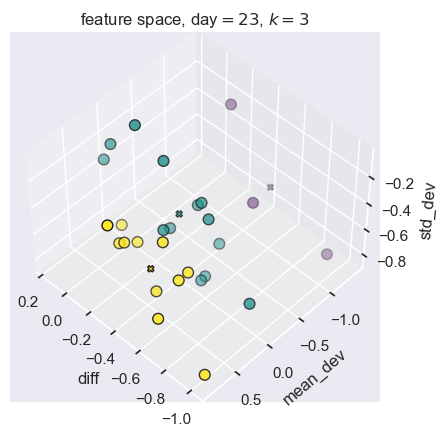

In [221]:
plot_feature_space_3d(n_clusters, ftrs, nday)

In [222]:
def plot_params(n_clusters, ftrs, nday, data=tmp_ftrs_scaled):
    # clustering
    kmeans, ftrs_df = kmeans_single_day(n_clusters, ftrs, nday, data)
    # add labels
    plt_data = tmp_ftrs[tmp_ftrs.day == nday].dropna()
    plt_data["label"] = kmeans.labels_
    # plotting
    fig, ax = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={"wspace": 0.3})
    sns.countplot(data=plt_data, x="label", ax=ax[0])
    sns.boxplot(data=plt_data, x="label", y="nans", ax=ax[1])
    sns.boxplot(data=plt_data, x="label", y="alt", ax=ax[2])
    fig.suptitle(rf"day$ = {nday}$, ftrs$=$({', '.join(ftrs)})")

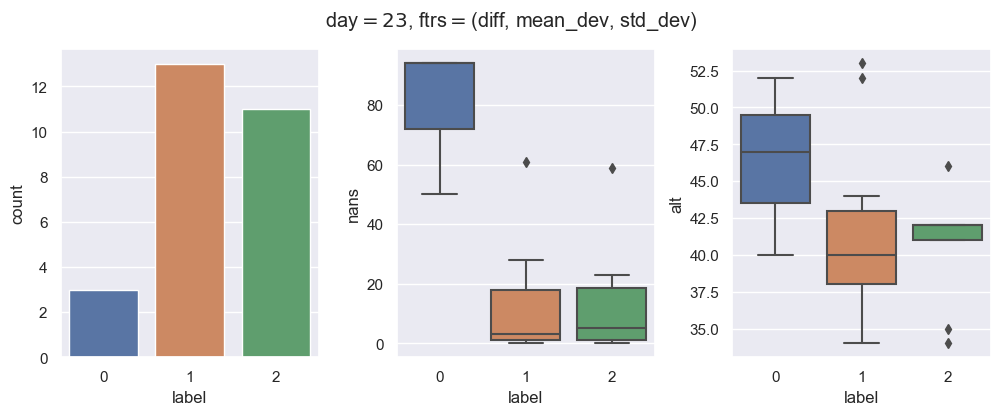

In [223]:
plot_params(n_clusters, ftrs, nday)

In [224]:
def find_clusters(n_clusters, ftrs, nday, subfolder, data=tmp_ftrs_scaled):
    """
    Clustering for individual day.
    (!) Do not forget to create subfolder manually.
    Returns fitted algorithm.
    """
    # clustering
    kmeans, ftrs_df = kmeans_single_day(n_clusters, ftrs, nday, data)
    print(
        "kmeans for day #"+str(nday),
        "\n\t> SSE =",kmeans.inertia_,
        "\n\t> # of iters =",kmeans.n_iter_,
    )

    df = data[data.day == nday].dropna() # "id" column is needed for merging loc data
    # add messi location data -> new data frame for plotting section
    day_loc = df.merge(right=messi_loc[["id", "lon", "lat"]], 
                       how="left", on="id")
    # the order of messis does not change, hence, adding labels to dataframe is
    # as simple as:
    day_loc["label"] = kmeans.labels_

    # plotting...
    trans = ccrs.PlateCarree() # do not change!
    bg = cimgt.OSM() # background map

    fig, ax = plt.subplots(subplot_kw={"projection": bg.crs})
    ax.set_extent([13.0, 13.7, 52.65, 52.37], crs=trans)
    sns.scatterplot(data=day_loc, x="lon", y="lat", hue="label", style="label",
                    palette="viridis", s=50, linewidth=0.5, ec="k", alpha=0.9,
                    transform=trans, ax=ax) #legend=False
    ax.add_image(bg, 12, alpha=0.9)
    ax.set_title(f"day = {nday}")
    fig.savefig(f"../figs/clusters_scaled/{subfolder}/clusters-{nday}.png",
                dpi=300, bbox_inches="tight")
    plt.close() # to prevent memory overflow

    return kmeans

In [225]:
def anim_clusters(days, subfolder):
    # save single frames into array
    frames = []
    for day in days:
        image = imageio.v2.imread(f"../figs/clusters_scaled/{subfolder}/clusters-{day}.png")
        frames.append(image)

    # combine frames to gif
    imageio.mimsave(
        f"../figs/clusters_scaled/{subfolder}/clusters.gif", 
        frames, 
        duration=1.5
    )

In [226]:
days = tmp_ftrs_scaled["day"].unique()
subfolder = "default-features"

kmeans = {}
for nday in days:
    kmeans[nday] = find_clusters(n_clusters, ftrs, nday, subfolder)

anim_clusters(days, subfolder)

kmeans for day #1 
	> SSE = 3.5878499208087016 
	> # of iters = 6
kmeans for day #2 
	> SSE = 5.158584766104291 
	> # of iters = 2
kmeans for day #3 
	> SSE = 6.142319110134831 
	> # of iters = 2
kmeans for day #4 
	> SSE = 36.42932824208273 
	> # of iters = 2
kmeans for day #5 
	> SSE = 4.790844964229091 
	> # of iters = 5
kmeans for day #6 
	> SSE = 4.084701831562812 
	> # of iters = 2
kmeans for day #7 
	> SSE = 4.614140716983069 
	> # of iters = 2
kmeans for day #8 
	> SSE = 12.411194386384249 
	> # of iters = 3
kmeans for day #9 
	> SSE = 2.9531023251783646 
	> # of iters = 2
kmeans for day #10 
	> SSE = 9.711152845391066 
	> # of iters = 3
kmeans for day #11 
	> SSE = 4.874287736856088 
	> # of iters = 2
kmeans for day #12 
	> SSE = 6.437681077739057 
	> # of iters = 3
kmeans for day #13 
	> SSE = 7.861236561715307 
	> # of iters = 5
kmeans for day #14 
	> SSE = 5.985838133512484 
	> # of iters = 2
kmeans for day #15 
	> SSE = 7.067303455321593 
	> # of iters = 2
kmeans for day #

In [227]:
def plot_sse(kmeans, n_clusters, ftrs):
    """
    kmeans = dict(days, kmean)
    """
    # get sse
    sse = []
    for kmean in kmeans.values():
        sse.append(kmean.inertia_)

    fig, ax = plt.subplots()
    sns.lineplot(x=list(kmeans.keys()), y=sse, marker="o")
    ax.set_title(rf"clustering, $k={n_clusters}$, ftrs$=$({', '.join(ftrs)})")
    ax.set_xlabel("day")
    ax.set_ylabel("SSE")

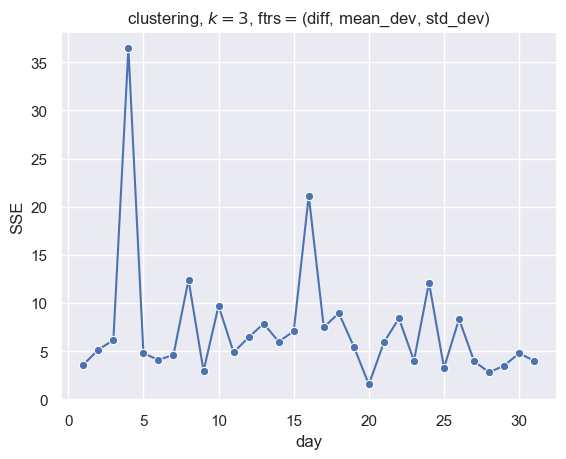

In [228]:
plot_sse(kmeans, n_clusters, ftrs)

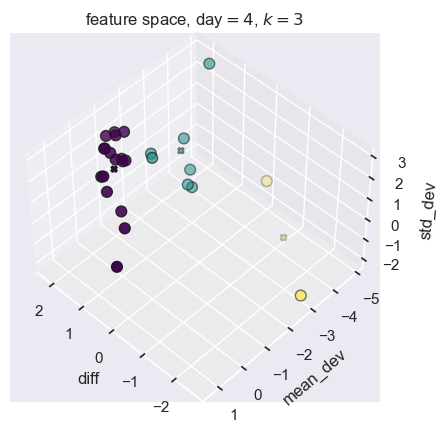

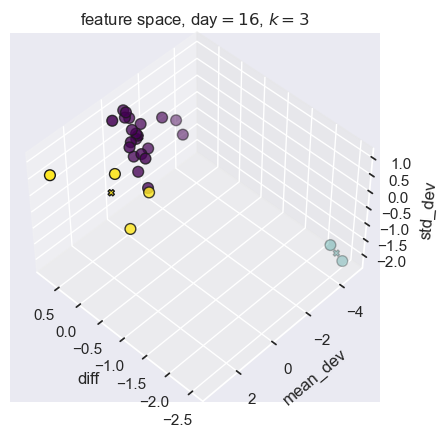

In [229]:
plot_feature_space_3d(n_clusters, ftrs, nday=4)
plot_feature_space_3d(n_clusters, ftrs, nday=16)

***

### Einschub: Completely Missing Days

If the number of data points isn't constant among the multiple clusterings, the metrics to evaluate performance can't be applied.

In [230]:
# all messi ids
ids = tmp_ftrs["id"].unique()

# messis with at least one day of not a single data point
ids_no_data = tmp_ftrs[tmp_ftrs.nans == 6*24]["id"].unique()

print("# of messis =",len(ids))
print("# of messis without data gaps =",len(ids)-len(ids_no_data))

# of messis = 32
# of messis without data gaps = 19


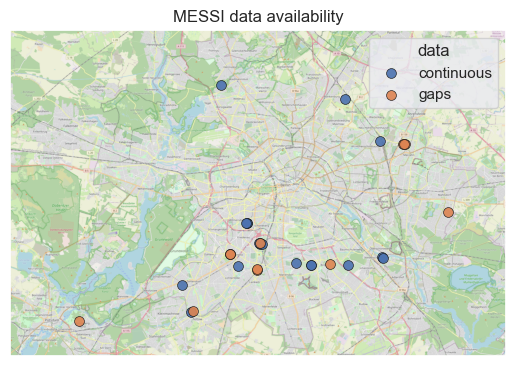

In [231]:
# visualize messi data availability on berlin map
messi_no_data = messi_loc[messi_loc.id.isin(ids_no_data)]
messi_si_data = messi_loc[~messi_loc.id.isin(ids_no_data)]

trans = ccrs.PlateCarree() # do not change!
bg = cimgt.OSM() # background map

fig, ax = plt.subplots(subplot_kw={"projection": bg.crs})
ax.set_extent([13.0, 13.7, 52.65, 52.37], crs=trans)


sns.scatterplot(data=messi_si_data, x="lon", y="lat", label="continuous",
                s=50, linewidth=0.5, ec="k", alpha=0.9, transform=trans, ax=ax)
sns.scatterplot(data=messi_no_data, x="lon", y="lat", label="gaps",
                s=50, linewidth=0.5, ec="k", alpha=0.9, transform=trans, ax=ax)

ax.legend(title="data")
ax.add_image(bg, 12, alpha=0.9)
ax.set_title("MESSI data availability")
fig.savefig(f"../figs/data-avail.png", dpi=300, bbox_inches="tight")

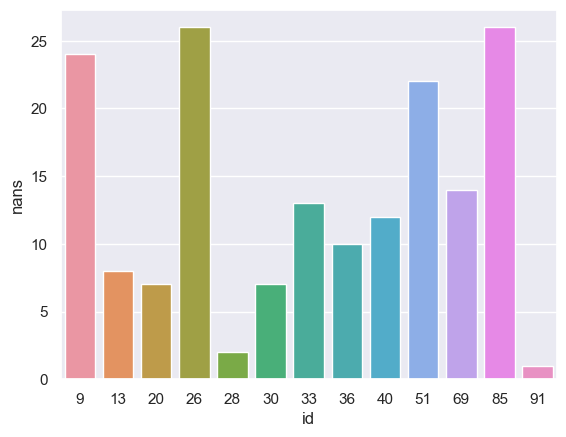

In [232]:
# How many (complete) days are missing per messi?
data = (tmp_ftrs
    [tmp_ftrs.nans == 6*24]
    .groupby("id", as_index=False)
    .count()
    .sort_values(by="day")
)

# messis with less than 10 missing days of data
ids_few_data = data[data.nans < 10]["id"].unique()

sns.barplot(data=data, x="id", y="nans");

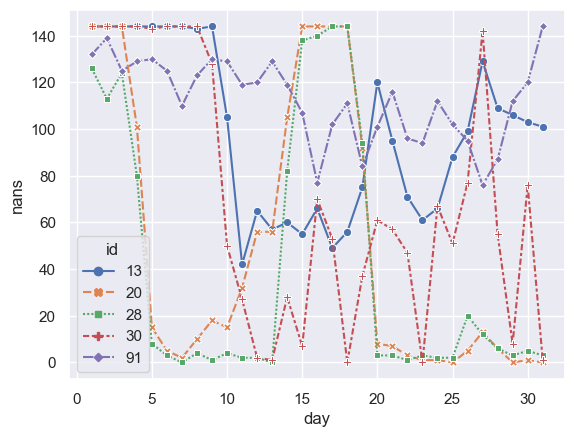

In [233]:
# Can particular days be omitted from future analysis to increase # of messis
# without data gap?
# explanation why the .copy() is needed:
# https://stackoverflow.com/questions/57700077/avoiding-settingwithcopywarning-while-converting-column-data-with-methods
data = tmp_ftrs[tmp_ftrs.id.isin(ids_few_data)].copy()
# convert to string so that seaborn treats it as a categorical variable
data["id"] = data["id"].astype(str)

sns.lineplot(data=data, x="day", y="nans", hue="id", style="id", markers=True);#marker=".");

No, it looks like omitting particular days wouldn't increase the number of available MESSIs greatly.

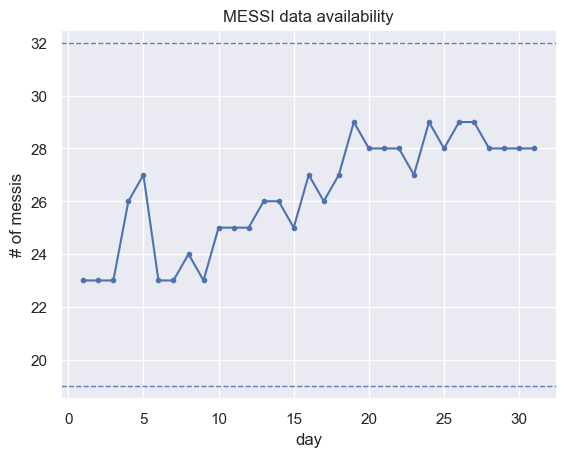

In [234]:
# How many messis are available per day?
data = tmp_ftrs_scaled.dropna()["day"].value_counts(sort=False)

fig, ax = plt.subplots()
ax.plot(days, data, marker=".")
ax.set_ylim(18.5, 32.5)
ax.axhline(19, ls="--", lw=1, alpha=0.9)
ax.axhline(32, ls="--", lw=1, alpha=0.9)
ax.set_xlabel("day")
ax.set_ylabel("# of messis")
ax.set_title("MESSI data availability");

***

## Clustering Performance Evaluation

This summary is based on information found in the [sklearn documentation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

The **Rand index** measures the similarity of two clusterings, *ignoring permutations*. The Rand index does not ensure to obtain a value close to zero for random labelling, the *adjusted* Rand index corrects for chance. Perfect labelling is a score of one.

The **Mutual Information** score delivers similar results, but is based on a different mathematical formulation.

For computing these evaluation metrics *only* MESSIs without data gaps (gap = lacking at least one complete day) are considered.

In [235]:
def eval_similarity(kmeans, days, n_clusters, ftrs):
    # get labels
    tmp_labels = pd.DataFrame()
    for k in days:
        df = tmp_ftrs[tmp_ftrs.day == k].dropna()
        df["label"] = kmeans[k].labels_
        tmp_labels = pd.concat([tmp_labels, df])

    # messis with at least one day of not a single data point
    ids_no_data = tmp_ftrs[tmp_ftrs.nans == 6*24]["id"].unique()
    # filter messis with data gaps
    tmp_labels_eval = tmp_labels[~tmp_labels.id.isin(ids_no_data)]

    # compute metrics
    ari = []
    ami = []
    for day in days[:-1]: # = range(1, 30)
        labels_today = tmp_labels_eval[tmp_labels_eval.day == day]["label"]
        labels_nextday = tmp_labels_eval[tmp_labels_eval.day == day + 1]["label"]
        ari.append(
            adjusted_rand_score(labels_today, labels_nextday)
        )
        ami.append(
            adjusted_mutual_info_score(labels_today, labels_nextday)
        )

    # plotting...
    fig, ax = plt.subplots()
    ax.plot(days[:-1], ari, label="ARI", marker="o")
    ax.plot(days[:-1], ami, label="AMI", marker="X")
    ax.set_ylim(top=1.0)
    ax.set_xlabel(r"$i$th comparison (day$_i$ ~ day$_{i+1}$)")
    ax.set_ylabel("score value")
    ax.set_title(rf"Similarity of clusters, $k={n_clusters}$, ftrs$=$({', '.join(ftrs)})")
    ax.legend(title="eval metric")

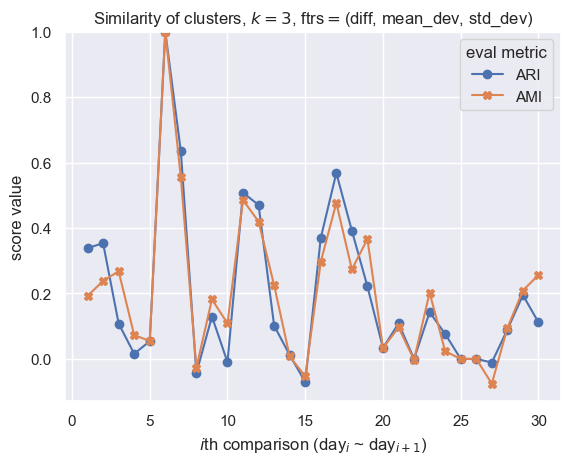

In [236]:
eval_similarity(kmeans, days, n_clusters, ftrs)

## AUTOMATION: Other feature combinations

Now, the functions can be used to easily run alternative clustering approaches.

#### `diff`, `mean`, `std`

Mean and standard deviation aren't defined using deviation from dwd mean daily temperature.

# of clusters 1 	# of iterations: 2 	# of features: 3
# of clusters 2 	# of iterations: 4 	# of features: 3
# of clusters 3 	# of iterations: 3 	# of features: 3
# of clusters 4 	# of iterations: 3 	# of features: 3
# of clusters 5 	# of iterations: 3 	# of features: 3
# of clusters 6 	# of iterations: 3 	# of features: 3
# of clusters 7 	# of iterations: 2 	# of features: 3
# of clusters 8 	# of iterations: 3 	# of features: 3
# of clusters 9 	# of iterations: 3 	# of features: 3
# of clusters 10 	# of iterations: 3 	# of features: 3
# of clusters 1 	# of iterations: 2 	# of features: 3
# of clusters 2 	# of iterations: 2 	# of features: 3
# of clusters 3 	# of iterations: 2 	# of features: 3
# of clusters 4 	# of iterations: 2 	# of features: 3
# of clusters 5 	# of iterations: 4 	# of features: 3
# of clusters 6 	# of iterations: 3 	# of features: 3
# of clusters 7 	# of iterations: 3 	# of features: 3
# of clusters 8 	# of iterations: 3 	# of features: 3
# of clusters 9 	# of itera

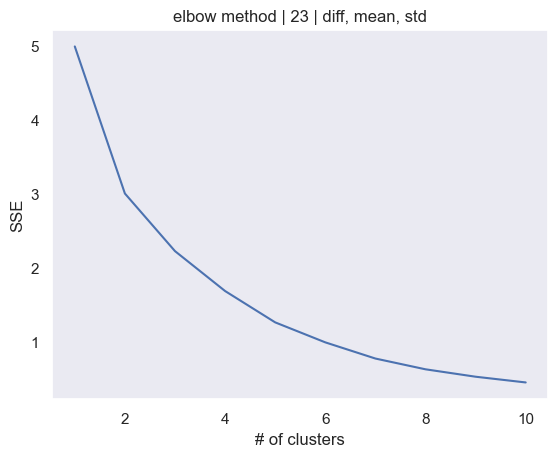

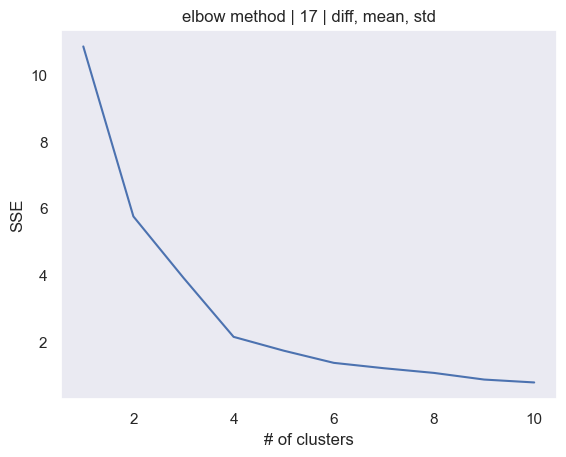

In [237]:
ftrs = ["diff", "mean", "std"]
nday = 23
elbow(ftrs, nday)
elbow(ftrs, nday=17)

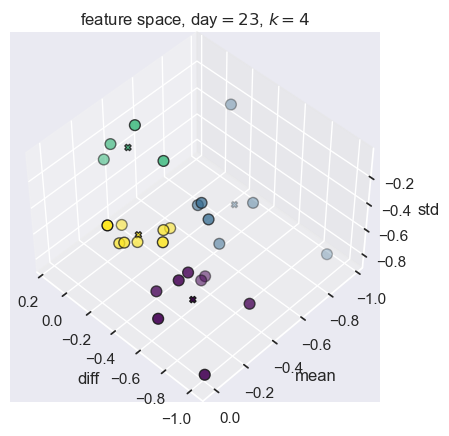

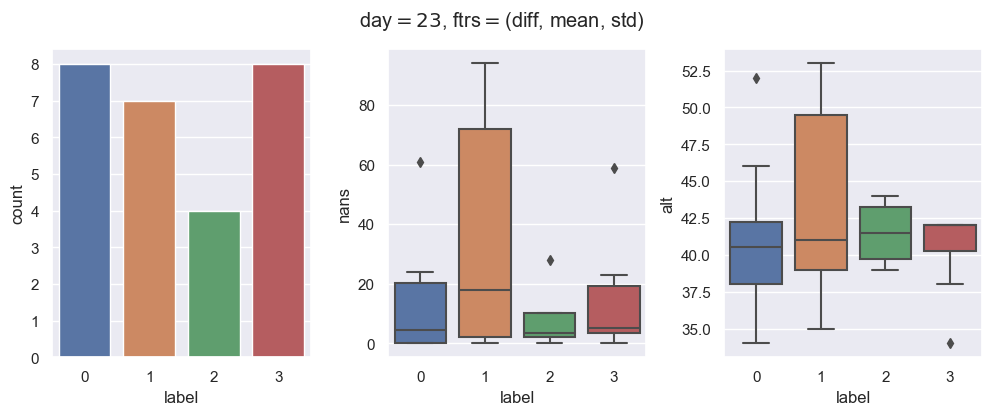

In [238]:
n_clusters = 4
plot_feature_space_3d(n_clusters, ftrs, nday)
plot_params(n_clusters, ftrs, nday)

kmeans for day #1 
	> SSE = 1.126703912775924 
	> # of iters = 3
kmeans for day #2 
	> SSE = 2.2948096830626623 
	> # of iters = 4
kmeans for day #3 
	> SSE = 2.5998688049135916 
	> # of iters = 4
kmeans for day #4 
	> SSE = 12.296641685910268 
	> # of iters = 5
kmeans for day #5 
	> SSE = 1.937475519934766 
	> # of iters = 3
kmeans for day #6 
	> SSE = 1.447294917442843 
	> # of iters = 5
kmeans for day #7 
	> SSE = 1.8996219002511392 
	> # of iters = 2
kmeans for day #8 
	> SSE = 3.5013058165848694 
	> # of iters = 4
kmeans for day #9 
	> SSE = 1.1657616716000438 
	> # of iters = 5
kmeans for day #10 
	> SSE = 3.1607176366433523 
	> # of iters = 3
kmeans for day #11 
	> SSE = 1.4821795364814758 
	> # of iters = 5
kmeans for day #12 
	> SSE = 2.2144350909915387 
	> # of iters = 4
kmeans for day #13 
	> SSE = 2.6470969888830878 
	> # of iters = 3
kmeans for day #14 
	> SSE = 1.9132981996814742 
	> # of iters = 3
kmeans for day #15 
	> SSE = 1.8719121989548912 
	> # of iters = 2
kmeans 

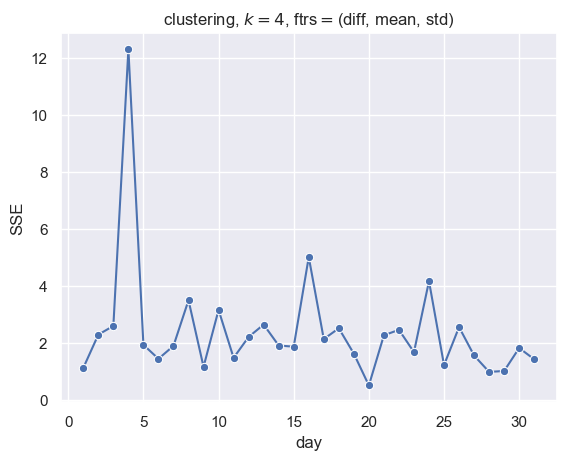

In [239]:
days = tmp_ftrs_scaled["day"].unique()
subfolder = "no-dev-features"

kmeans = {}
for nday in days:
    kmeans[nday] = find_clusters(n_clusters, ftrs, nday, subfolder)

anim_clusters(days, subfolder)
plot_sse(kmeans, n_clusters, ftrs)

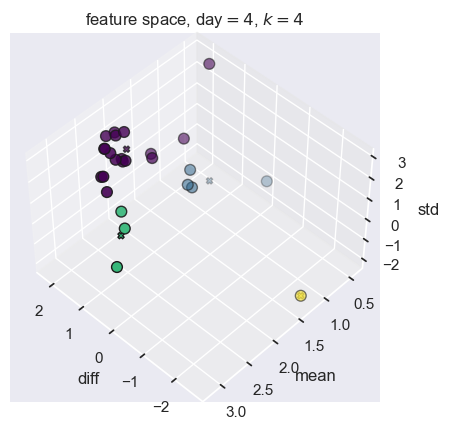

In [240]:
plot_feature_space_3d(n_clusters, ftrs, nday=4)

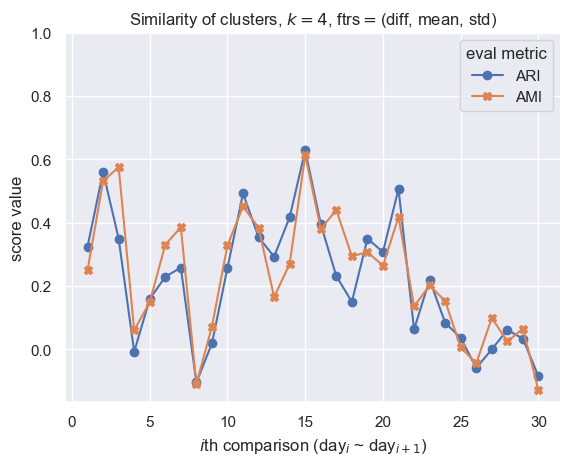

In [241]:
eval_similarity(kmeans, days, n_clusters, ftrs)

#### `diff`, `mean_dev`

Remember, there's a high correlation between `diff` and `std`/`std_dev`, so let's omit the latter.

# of clusters 1 	# of iterations: 2 	# of features: 2
# of clusters 2 	# of iterations: 2 	# of features: 2
# of clusters 3 	# of iterations: 5 	# of features: 2
# of clusters 4 	# of iterations: 5 	# of features: 2
# of clusters 5 	# of iterations: 3 	# of features: 2
# of clusters 6 	# of iterations: 4 	# of features: 2
# of clusters 7 	# of iterations: 3 	# of features: 2
# of clusters 8 	# of iterations: 2 	# of features: 2
# of clusters 9 	# of iterations: 3 	# of features: 2
# of clusters 10 	# of iterations: 3 	# of features: 2


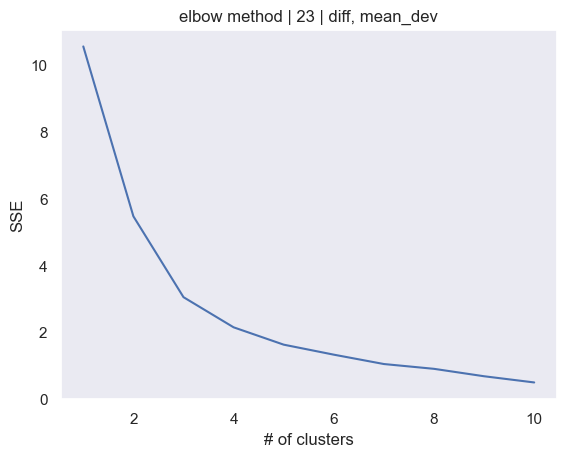

In [242]:
ftrs = ["diff", "mean_dev"]
nday = 23
elbow(ftrs, nday)

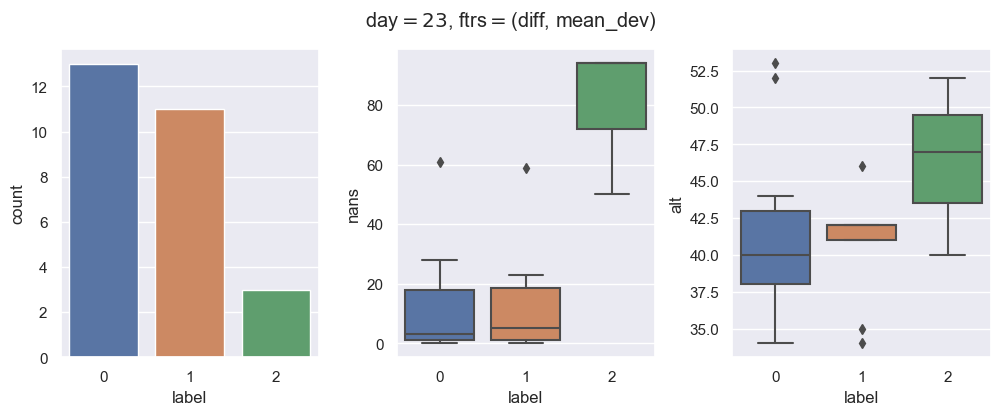

In [243]:
n_clusters = 3
#plot_feature_space_3d(n_clusters, ftrs, nday)
plot_params(n_clusters, ftrs, nday)

kmeans for day #1 
	> SSE = 2.8367422322089717 
	> # of iters = 3
kmeans for day #2 
	> SSE = 2.6671761731967063 
	> # of iters = 2
kmeans for day #3 
	> SSE = 4.288254660372006 
	> # of iters = 2
kmeans for day #4 
	> SSE = 24.514054538032934 
	> # of iters = 2
kmeans for day #5 
	> SSE = 3.7153201427892855 
	> # of iters = 4
kmeans for day #6 
	> SSE = 3.0201366136952217 
	> # of iters = 2
kmeans for day #7 
	> SSE = 3.451839343758089 
	> # of iters = 3
kmeans for day #8 
	> SSE = 10.931423001186921 
	> # of iters = 2
kmeans for day #9 
	> SSE = 2.3588800691274647 
	> # of iters = 4
kmeans for day #10 
	> SSE = 6.531896267106382 
	> # of iters = 2
kmeans for day #11 
	> SSE = 3.489626725919675 
	> # of iters = 4
kmeans for day #12 
	> SSE = 4.285728871838008 
	> # of iters = 3
kmeans for day #13 
	> SSE = 6.0666207456927435 
	> # of iters = 2
kmeans for day #14 
	> SSE = 4.209198024790371 
	> # of iters = 2
kmeans for day #15 
	> SSE = 5.660584157096554 
	> # of iters = 2
kmeans for 

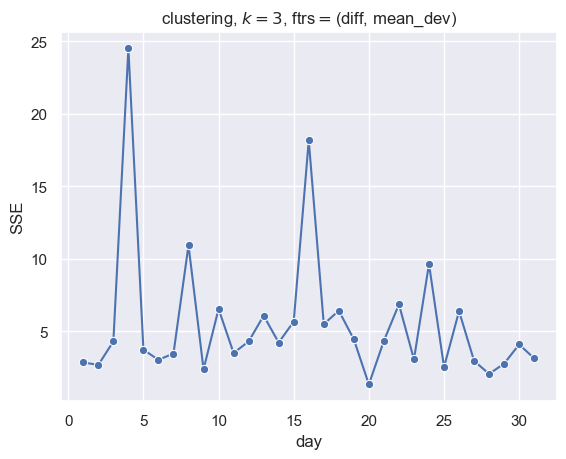

In [244]:
days = tmp_ftrs_scaled["day"].unique()
subfolder = "diff-mean-features"

kmeans = {}
for nday in days:
    kmeans[nday] = find_clusters(n_clusters, ftrs, nday, subfolder)

anim_clusters(days, subfolder)
plot_sse(kmeans, n_clusters, ftrs)

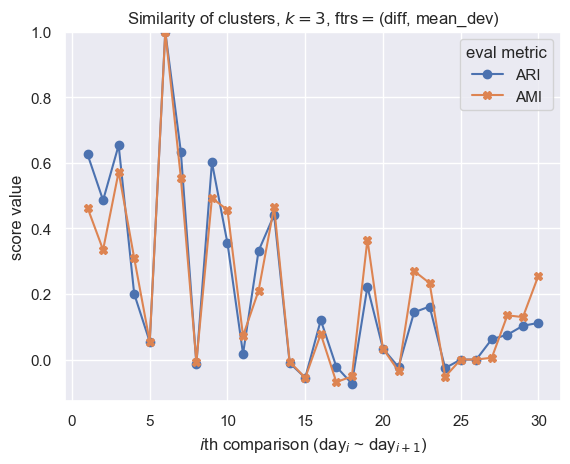

In [245]:
eval_similarity(kmeans, days, n_clusters, ftrs)

#### `diff`, `mean_dev`, `alt`

Altitude instead of standard deviation.

# of clusters 1 	# of iterations: 2 	# of features: 3
# of clusters 2 	# of iterations: 8 	# of features: 3
# of clusters 3 	# of iterations: 8 	# of features: 3
# of clusters 4 	# of iterations: 4 	# of features: 3
# of clusters 5 	# of iterations: 4 	# of features: 3
# of clusters 6 	# of iterations: 2 	# of features: 3
# of clusters 7 	# of iterations: 4 	# of features: 3
# of clusters 8 	# of iterations: 3 	# of features: 3
# of clusters 9 	# of iterations: 3 	# of features: 3
# of clusters 10 	# of iterations: 3 	# of features: 3
# of clusters 1 	# of iterations: 2 	# of features: 3
# of clusters 2 	# of iterations: 3 	# of features: 3
# of clusters 3 	# of iterations: 5 	# of features: 3
# of clusters 4 	# of iterations: 3 	# of features: 3
# of clusters 5 	# of iterations: 6 	# of features: 3
# of clusters 6 	# of iterations: 2 	# of features: 3
# of clusters 7 	# of iterations: 2 	# of features: 3
# of clusters 8 	# of iterations: 2 	# of features: 3
# of clusters 9 	# of itera

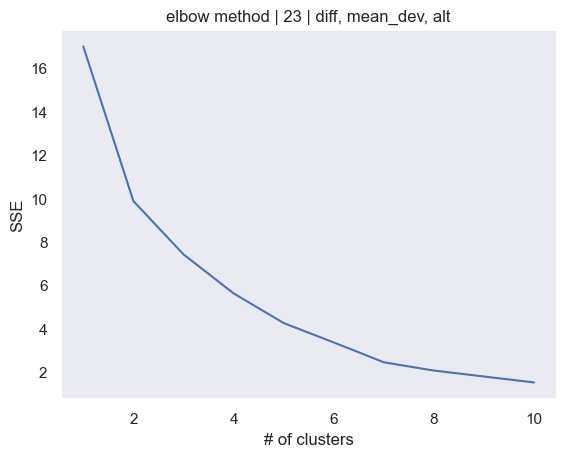

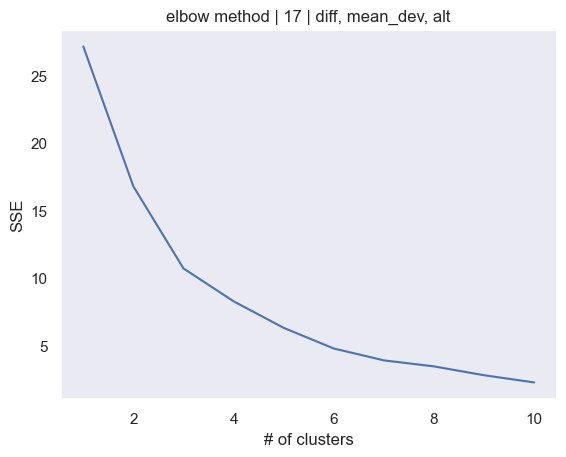

In [246]:
ftrs = ["diff", "mean_dev", "alt"]
nday = 23
elbow(ftrs, nday)
elbow(ftrs, nday=17)

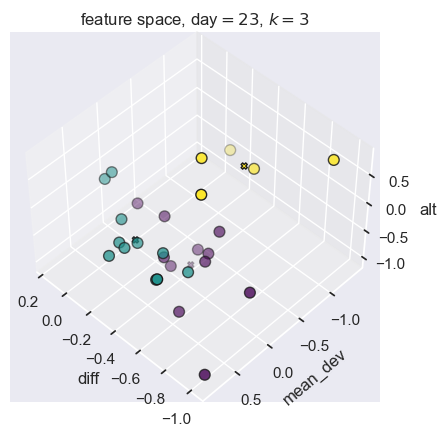

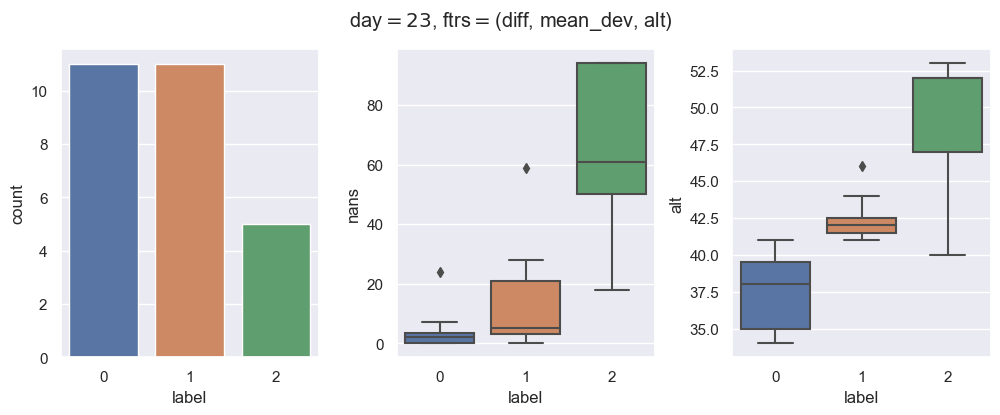

In [247]:
n_clusters = 3
plot_feature_space_3d(n_clusters, ftrs, nday)
plot_params(n_clusters, ftrs, nday)

kmeans for day #1 
	> SSE = 8.04564889237774 
	> # of iters = 2
kmeans for day #2 
	> SSE = 8.780402035135484 
	> # of iters = 3
kmeans for day #3 
	> SSE = 11.915844953868001 
	> # of iters = 2
kmeans for day #4 
	> SSE = 39.615543614962945 
	> # of iters = 3
kmeans for day #5 
	> SSE = 18.763363854696138 
	> # of iters = 2
kmeans for day #6 
	> SSE = 11.625871358854603 
	> # of iters = 3
kmeans for day #7 
	> SSE = 10.052901806217008 
	> # of iters = 2
kmeans for day #8 
	> SSE = 22.6337386074211 
	> # of iters = 2
kmeans for day #9 
	> SSE = 5.985342436500119 
	> # of iters = 3
kmeans for day #10 
	> SSE = 12.395670305621403 
	> # of iters = 2
kmeans for day #11 
	> SSE = 6.694525133226544 
	> # of iters = 5
kmeans for day #12 
	> SSE = 10.648940541309834 
	> # of iters = 4
kmeans for day #13 
	> SSE = 13.005232270899123 
	> # of iters = 4
kmeans for day #14 
	> SSE = 10.341378855871678 
	> # of iters = 2
kmeans for day #15 
	> SSE = 11.928933462675962 
	> # of iters = 2
kmeans for 

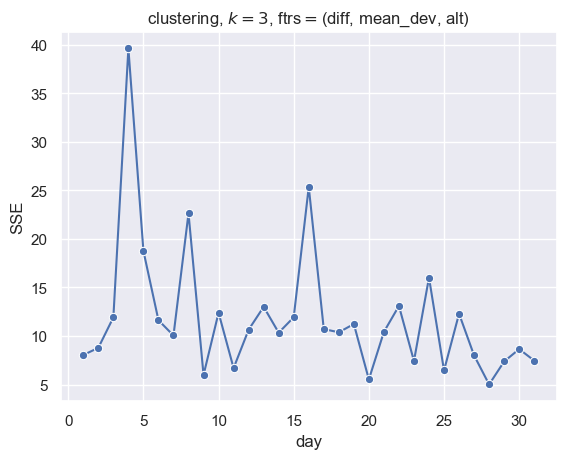

In [248]:
days = tmp_ftrs_scaled["day"].unique()
subfolder = "alt-features"

kmeans = {}
for nday in days:
    kmeans[nday] = find_clusters(n_clusters, ftrs, nday, subfolder)

anim_clusters(days, subfolder)
plot_sse(kmeans, n_clusters, ftrs)

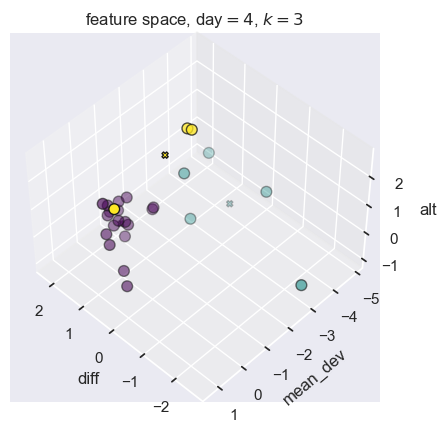

In [249]:
plot_feature_space_3d(n_clusters, ftrs, nday=4)

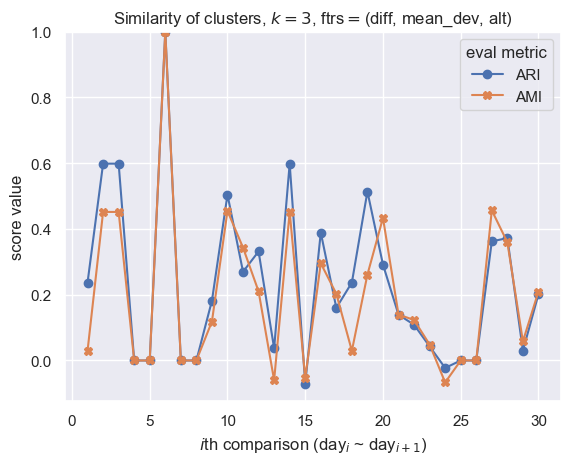

In [250]:
eval_similarity(kmeans, days, n_clusters, ftrs)